## Initial data analysis

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set_style("darkgrid")
colors = sns.color_palette("colorblind6")

# Path to the data
data_path = "./data/ClimateTrain.csv"

# Read as pandas dataframe and transform dates to datetime
df = pd.read_csv(data_path)
df['date'] = pd.to_datetime(df['date'])
# df.set_index('date', inplace=True)

# Plot description
df.describe()

,date,meantemp,humidity,wind_speed,meanpressure
count,1462,1462.000000,1462.000000,1462.000000,1462.000000
mean,2015-01-01 12:00:00,25.495521,60.771702,6.802209,1011.104548
min,2013-01-01 00:00:00,6.000000,13.428571,0.000000,-3.041667
25%,2014-01-01 06:00:00,18.857143,50.375000,3.475000,1001.580357
50%,2015-01-01 12:00:00,27.714286,62.625000,6.221667,1008.563492
75%,2016-01-01 18:00:00,31.305804,72.218750,9.238235,1014.944901
max,2017-01-01 00:00:00,38.714286,100.000000,42.220000,7679.333333
std,NaN,7.348103,16.769652,4.561602,180.231668


## Raw data

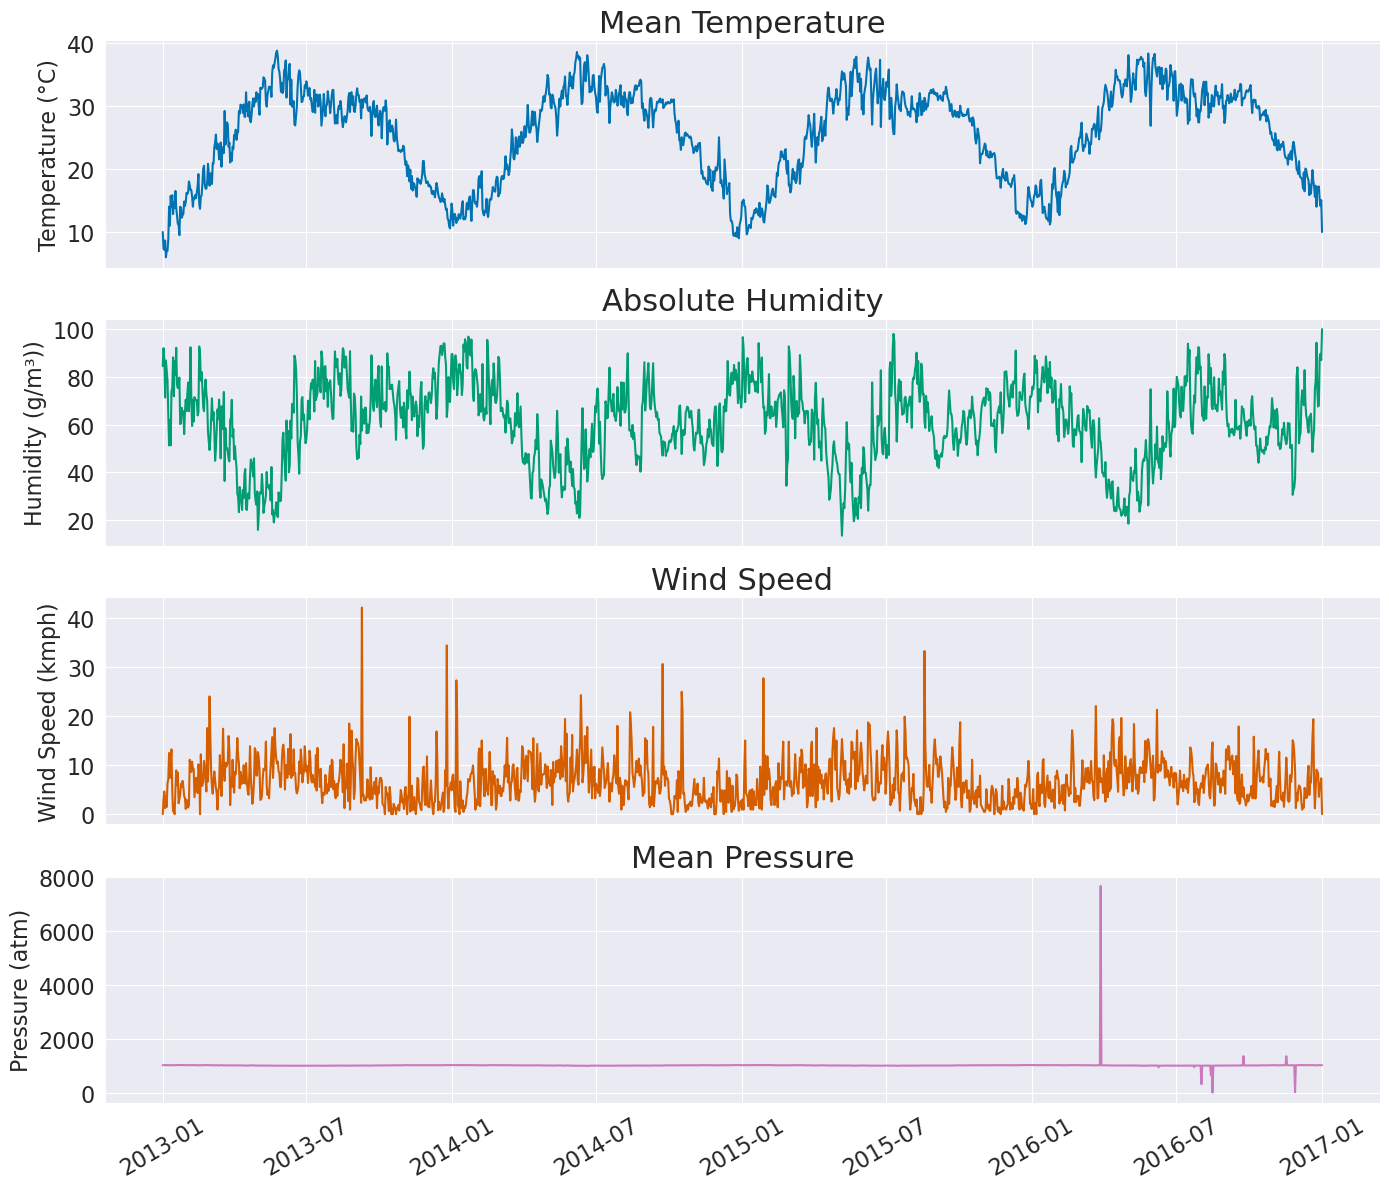

In [21]:
# Define labels etc.
titles = ["Mean Temperature", "Absolute Humidity", "Wind Speed", "Mean Pressure"]
ylabels = ["Temperature (°C)", "Humidity (g/m³))", "Wind Speed (kmph)", "Pressure (atm)"]

figure, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True) 

for idx, var in enumerate(df.columns[1:]):
    
    axes[idx].plot(df["date"], df[var], color=colors[idx])
    axes[idx].set_ylabel(ylabels[idx], fontsize=16)
    axes[idx].set_title(titles[idx], fontsize=22)
    axes[idx].tick_params(labelsize=16)

axes[3].tick_params(axis="x", rotation=30)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("./images/raw_data.pdf", format="pdf")
plt.show()

## Remove outliers


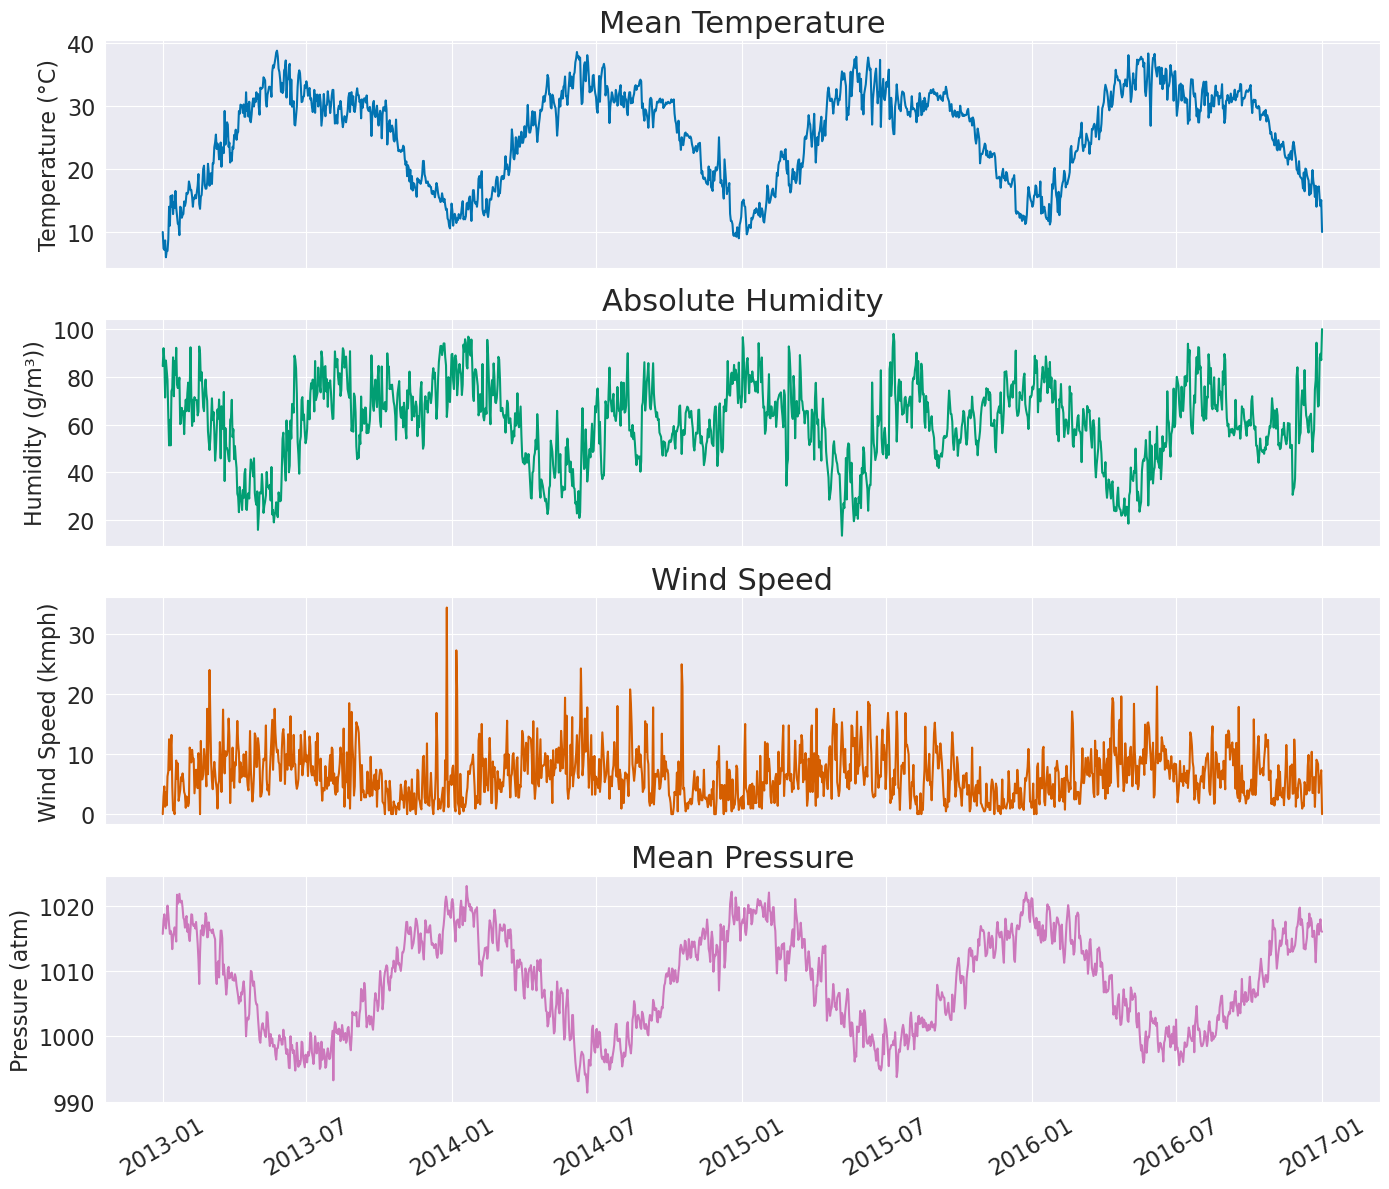

In [22]:
figure, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True) 

for idx, col in enumerate(df.columns[1:]):
    whole_period = df[col].dropna() # whole data
    normal_period = whole_period[: 2 * 365] # reference period (visually no major outliers here)
    
    roll = normal_period.rolling(window=30, min_periods=1, center=True) # Rolling window of 30 over the reference period
    roll_mean = roll.mean()
    roll_std = roll.std()

    mean = pd.concat([roll_mean, roll_mean.iloc[:1], roll_mean, roll_mean.iloc[:1]], ignore_index=True) # Repeat for almost the whole period
    std = pd.concat([roll_std, roll_std.iloc[:1], roll_std], ignore_index=True)

    z_score = (whole_period - mean) / std # Z-score based on the reference period

    out_bool = (z_score.abs() > 4) # Outliers are those with an absolute z-score greater than 3
    whole_period[out_bool] = mean[out_bool] # Replace outliers with the mean from the reference period

    axes[idx].plot(df["date"], whole_period, color=colors[idx])
    axes[idx].set_ylabel(ylabels[idx], fontsize=16)
    axes[idx].set_title(titles[idx], fontsize=22)
    axes[idx].tick_params(labelsize=16)
    df[col] = whole_period

axes[3].tick_params(axis="x", rotation=30)
plt.tight_layout()
plt.savefig("./images/clean_data.pdf", format="pdf")
plt.show()

## Test single seasonal decompose

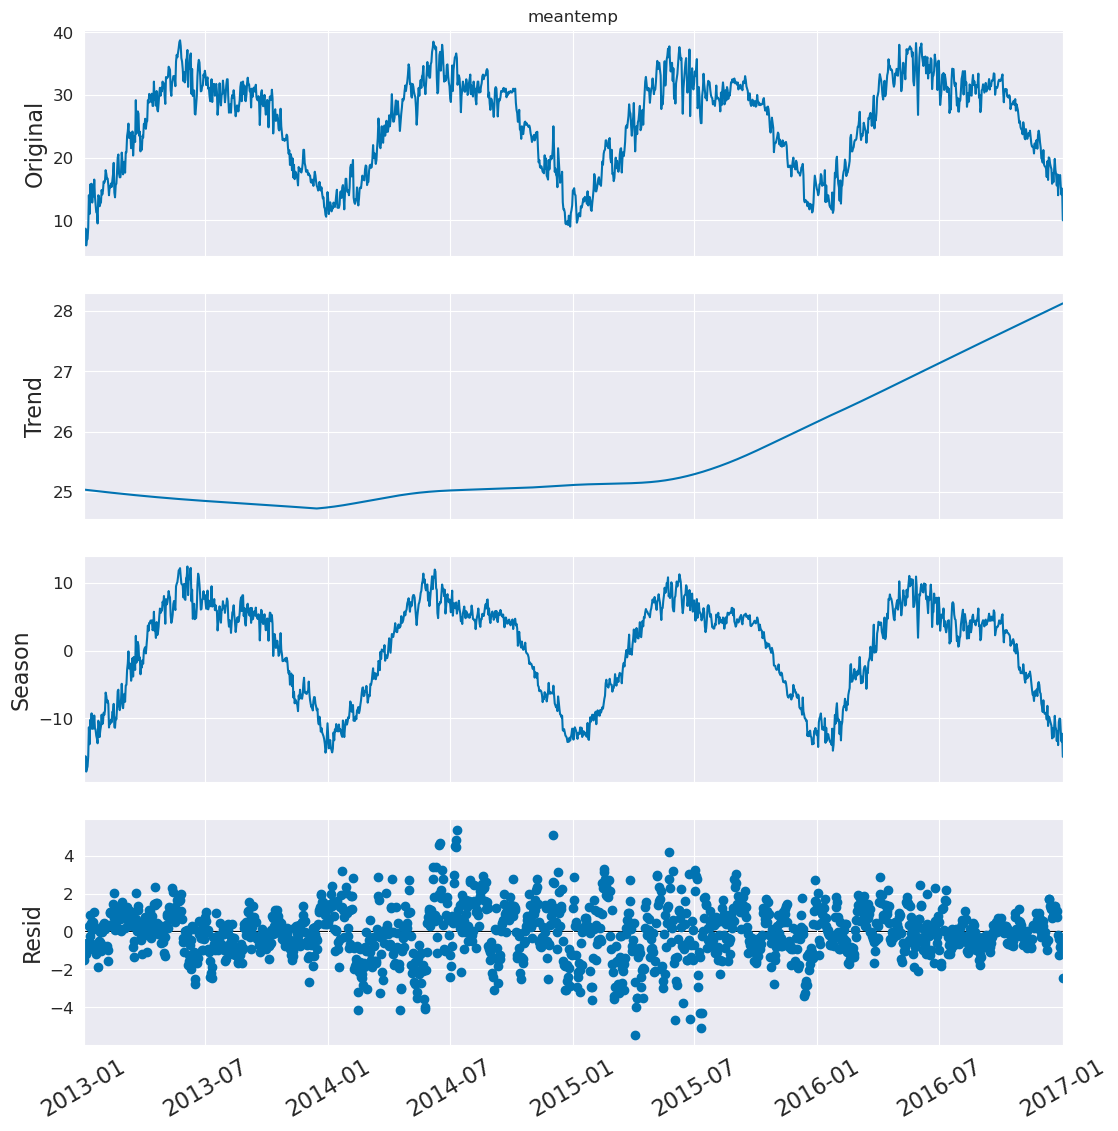

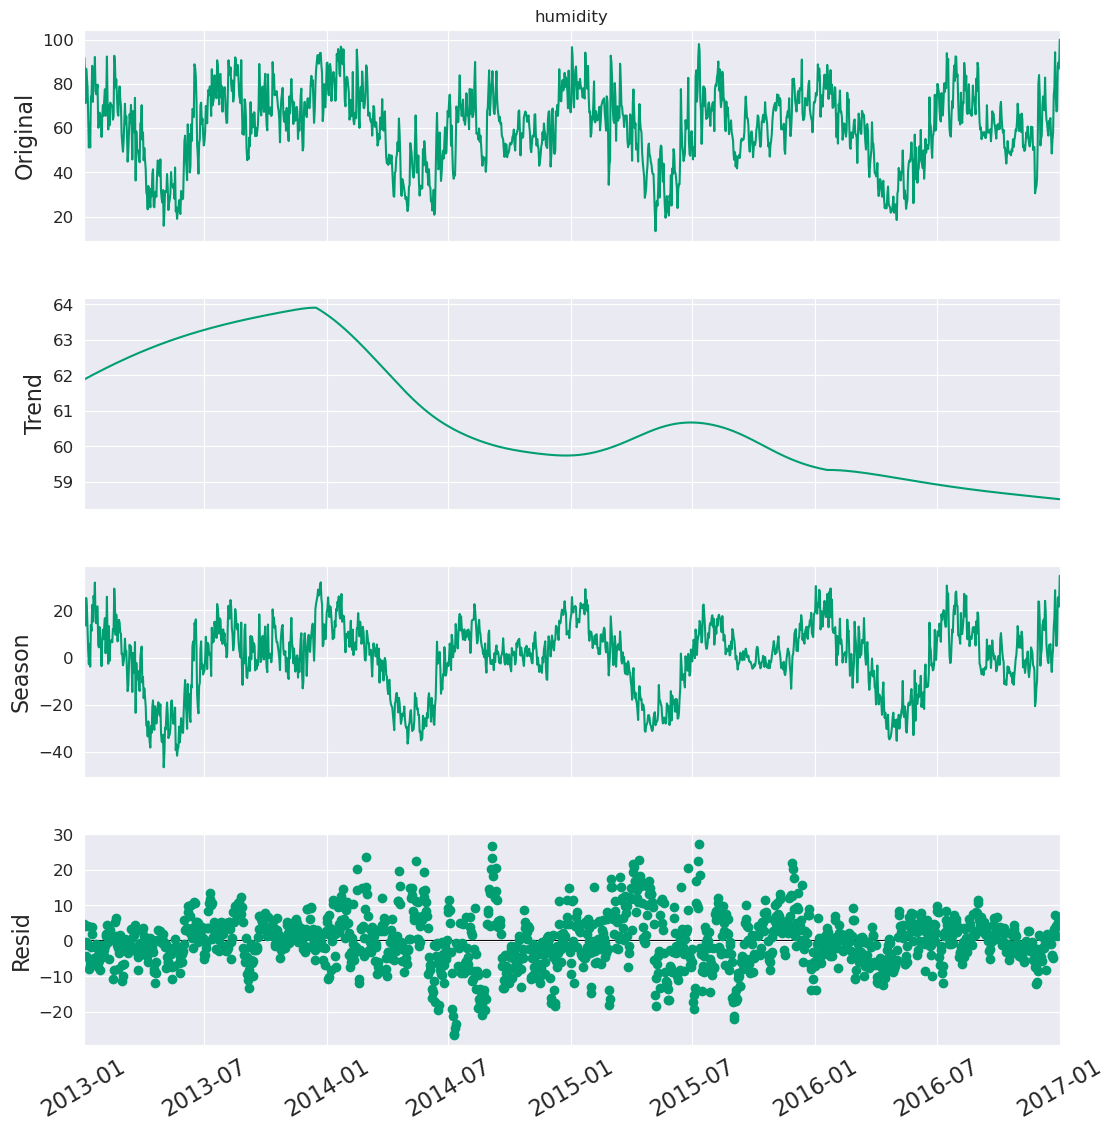

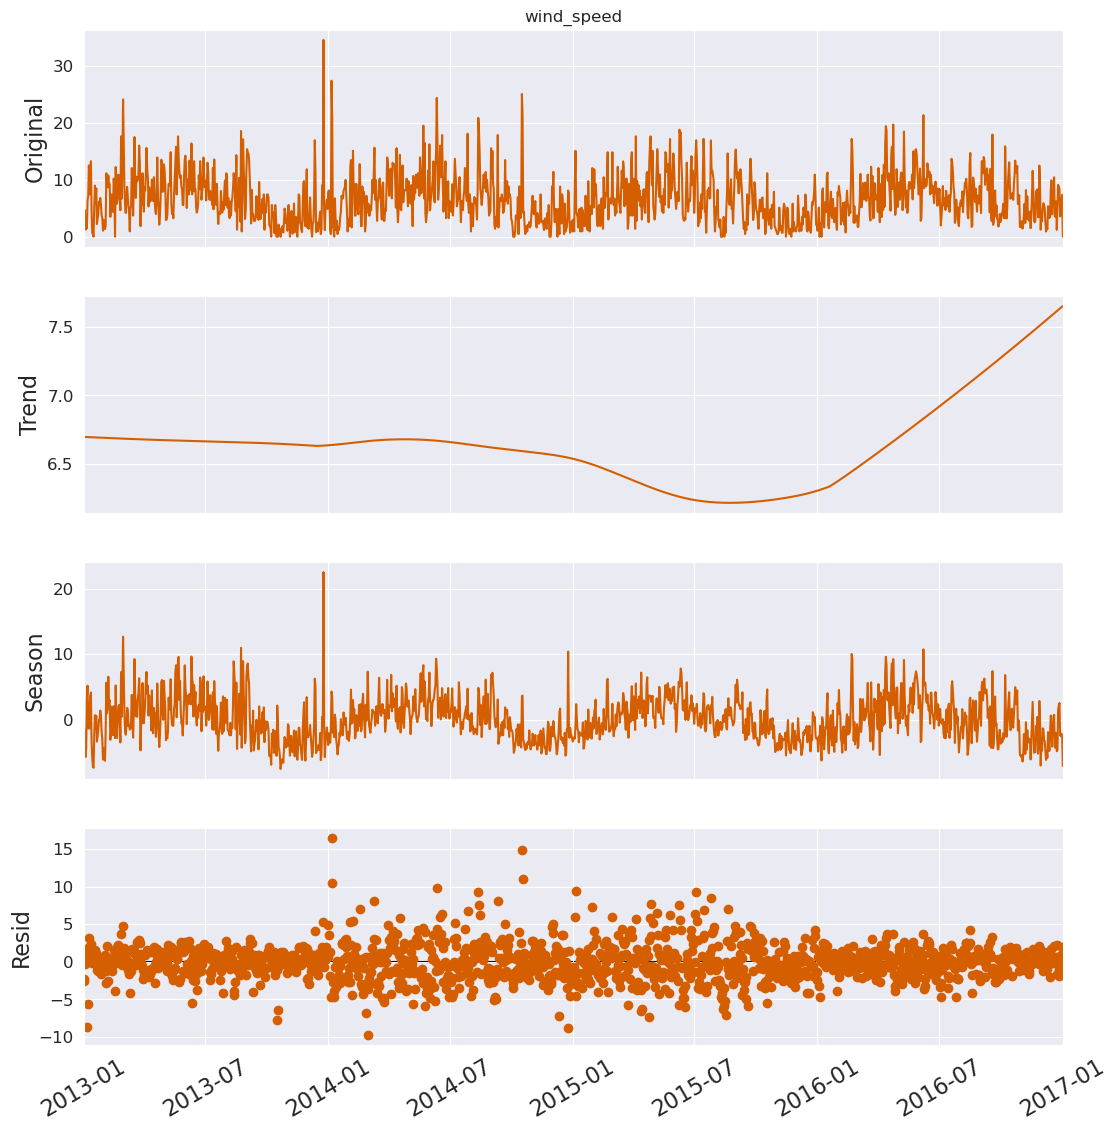

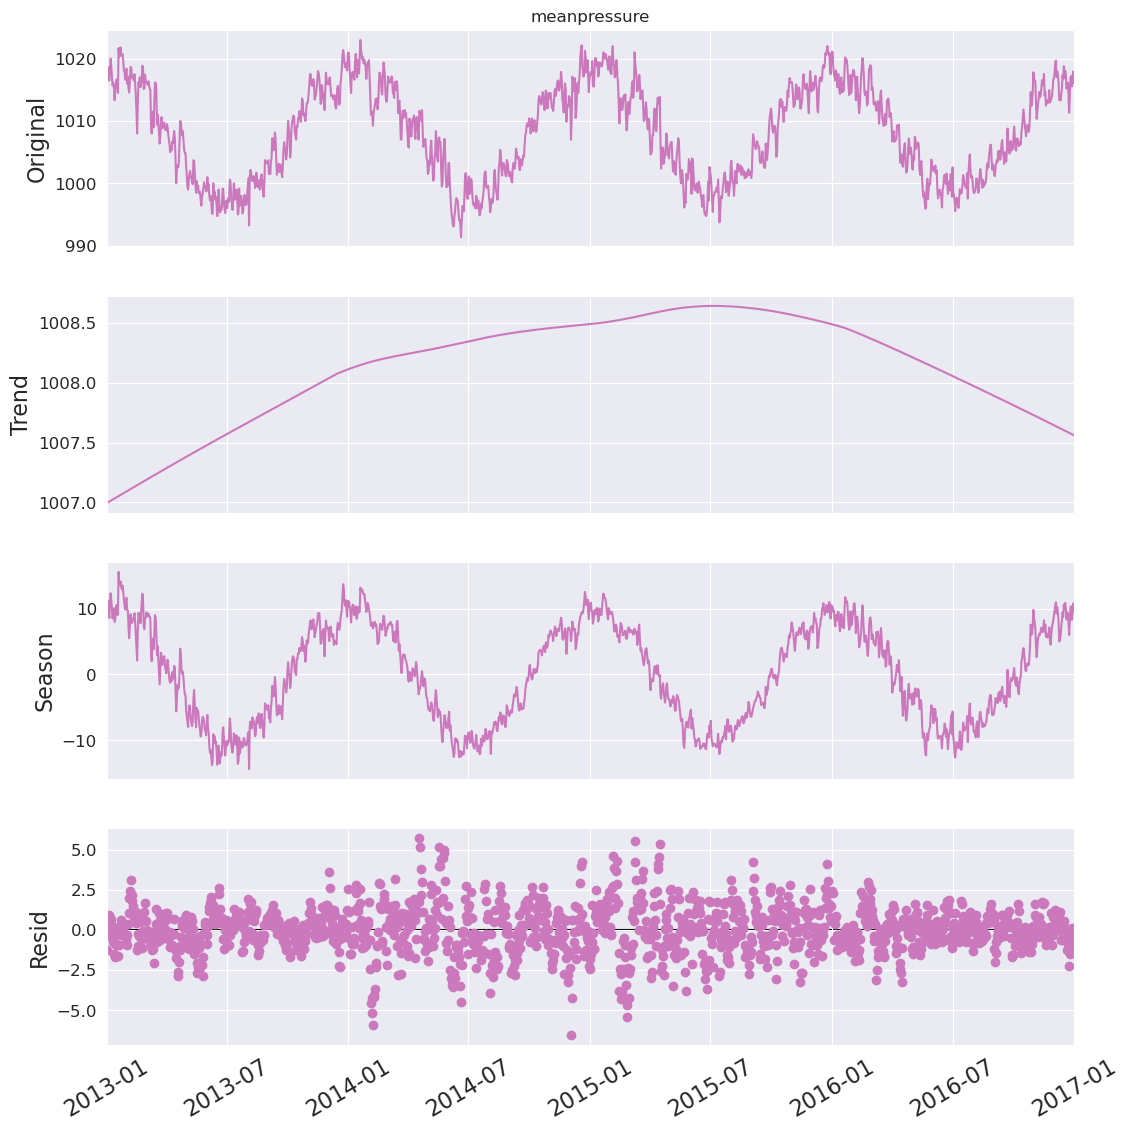

In [88]:
from statsmodels.tsa.seasonal import STL

def single_season_decompose(df, var, period):
    # Get column index
    idx = df.columns.get_loc(var)-1
    
    # Get variable data and set index to date
    data = df[var]
    data.index = df['date']
    
    # Decompose
    res = STL(data, period=period).fit()

    # Plot 
    fig = res.plot()
    fig.axes[0].set_title(var)           # remove title
    fig.axes[0].set_ylabel("Original")  # add as ylabel instead
    
    # Set colors
    for ax in fig.axes:
        ax.lines[0].set_color(colors[idx])
        ax.tick_params(axis="y", labelsize=12)
        ax.yaxis.label.set_fontsize(16)

    fig.set_size_inches((12, 12))
    plt.tick_params(axis="x", rotation=30, labelsize=16)
    # plt.savefig(f"./images/{var}_MSTL.pdf", format="pdf
    plt.show()

for var in df.columns[1:]:
    single_season_decompose(df, var, 365)


## Autocorrelation

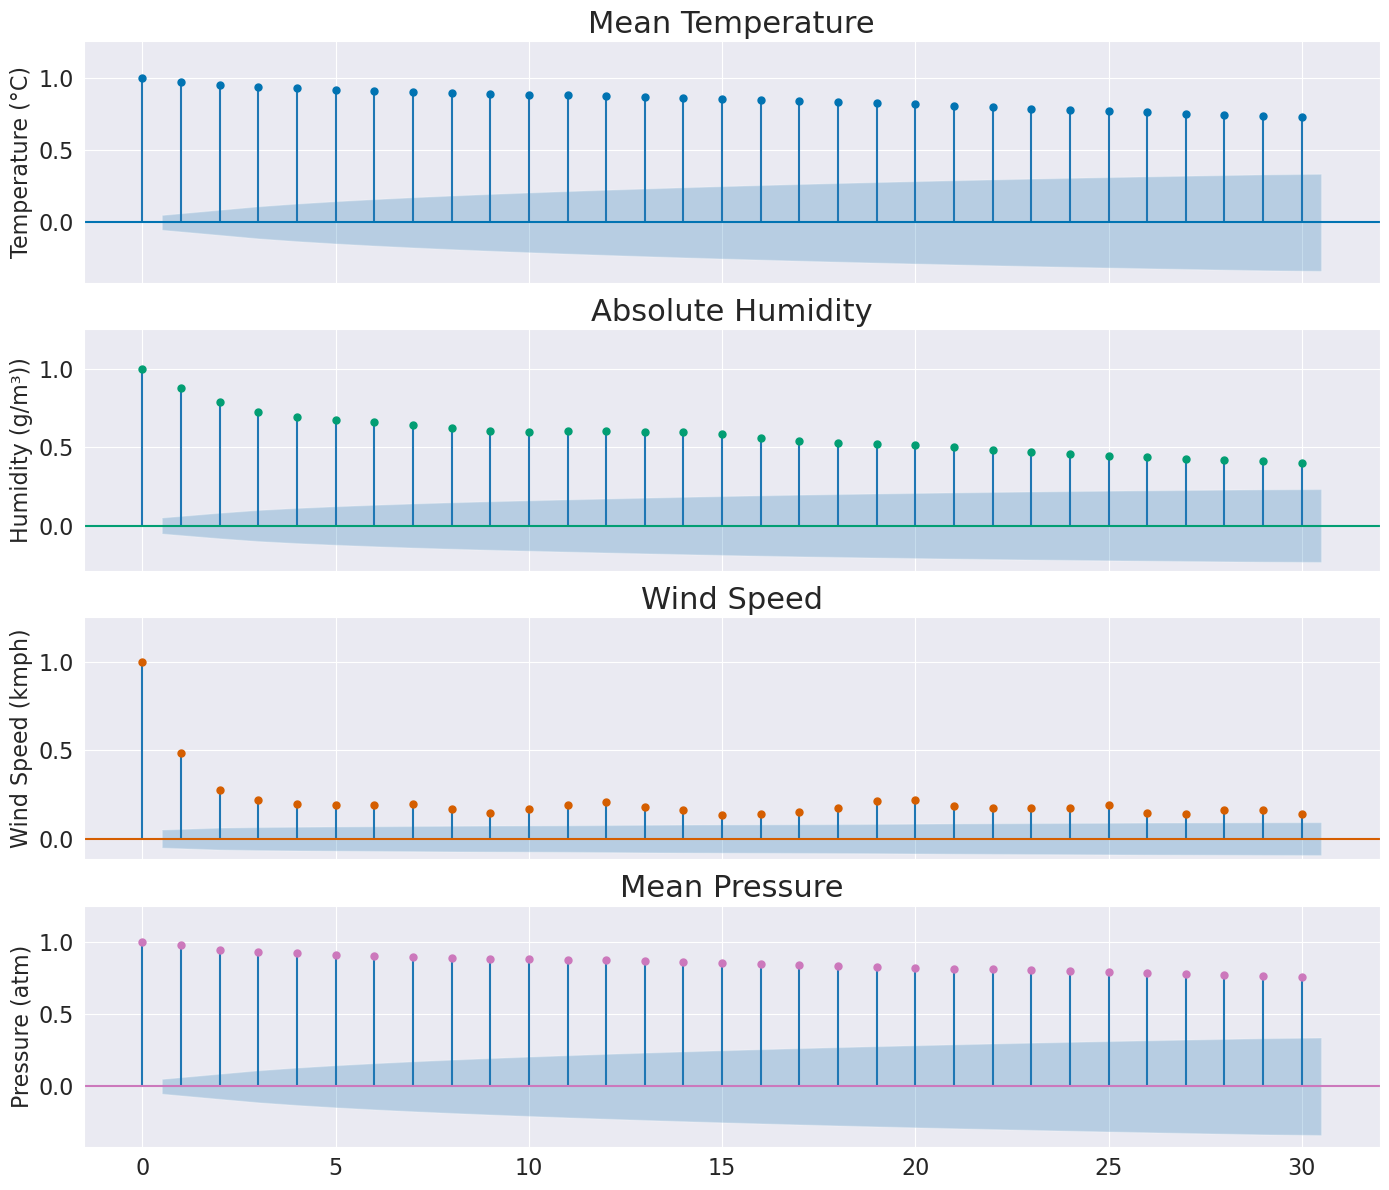

In [27]:
from statsmodels.graphics.tsaplots import plot_acf

figure, axes = plt.subplots(4,1, figsize=(14, 12), sharex=True)  # 4 rows, 1 column
mlag = 30
for idx, col in enumerate(df.columns[1:]):
    plot_acf(df[col], ax=axes[idx], lags=mlag, color=colors[idx], title=None, auto_ylims=True)
    #axes[i].acorr(df[col], maxlags=mlag, color=colors[i], normed=True)
    axes[idx].set_ylabel(ylabels[idx], fontsize=16)
    axes[idx].set_title(titles[idx], fontsize=22)
    axes[idx].tick_params(labelsize=16)

# axes[3].tick_params(axis="x", rotation=30)
# figure.suptitle(f"Autocorrelation of the features ({mlag} lags)")
plt.tight_layout()
# plt.savefig(f"./images/autocorrelation{mlag}.pdf", format="pdf")
plt.show()

## Decompose to multiple seasons instead

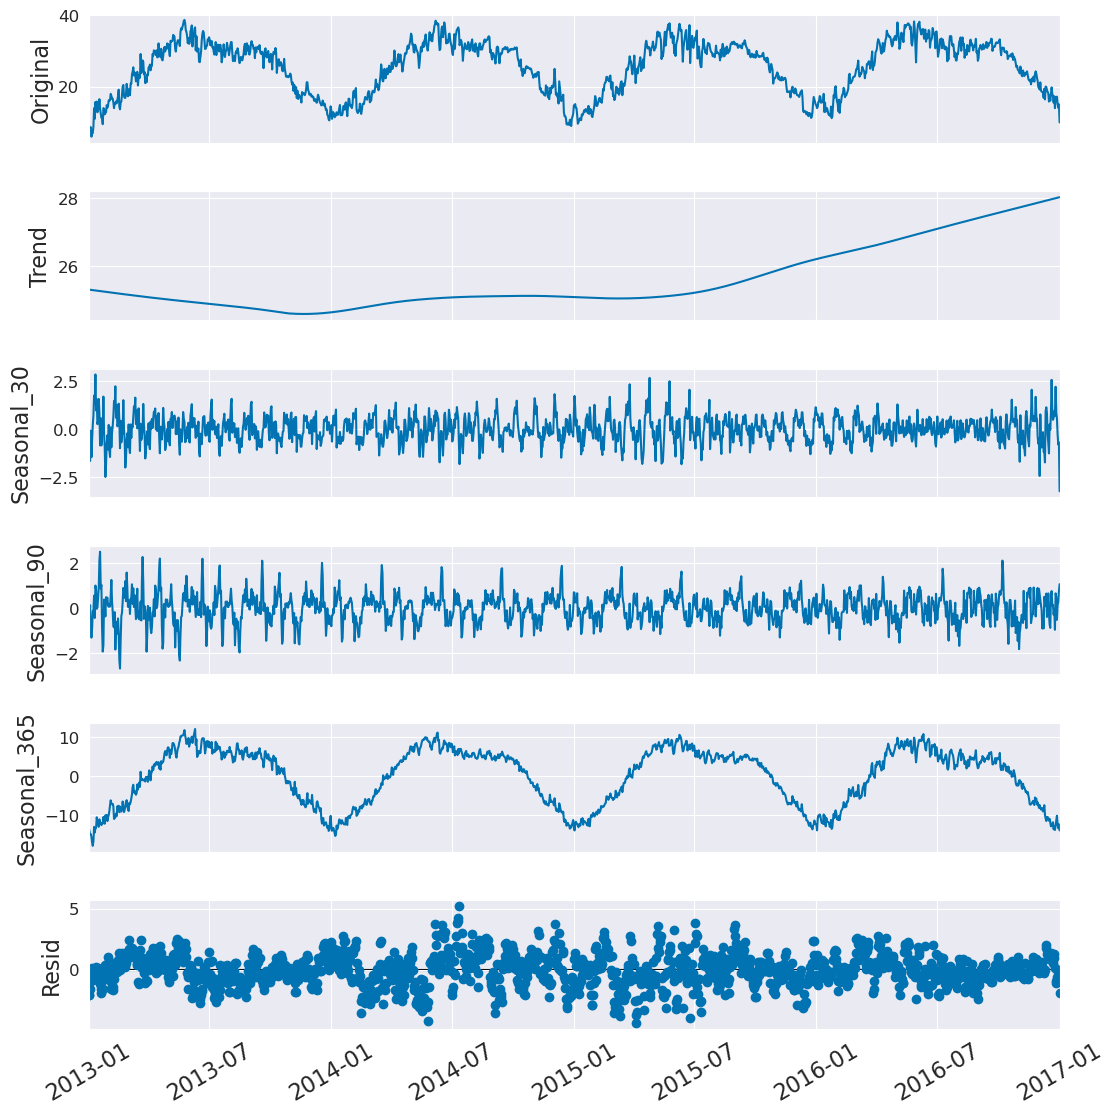

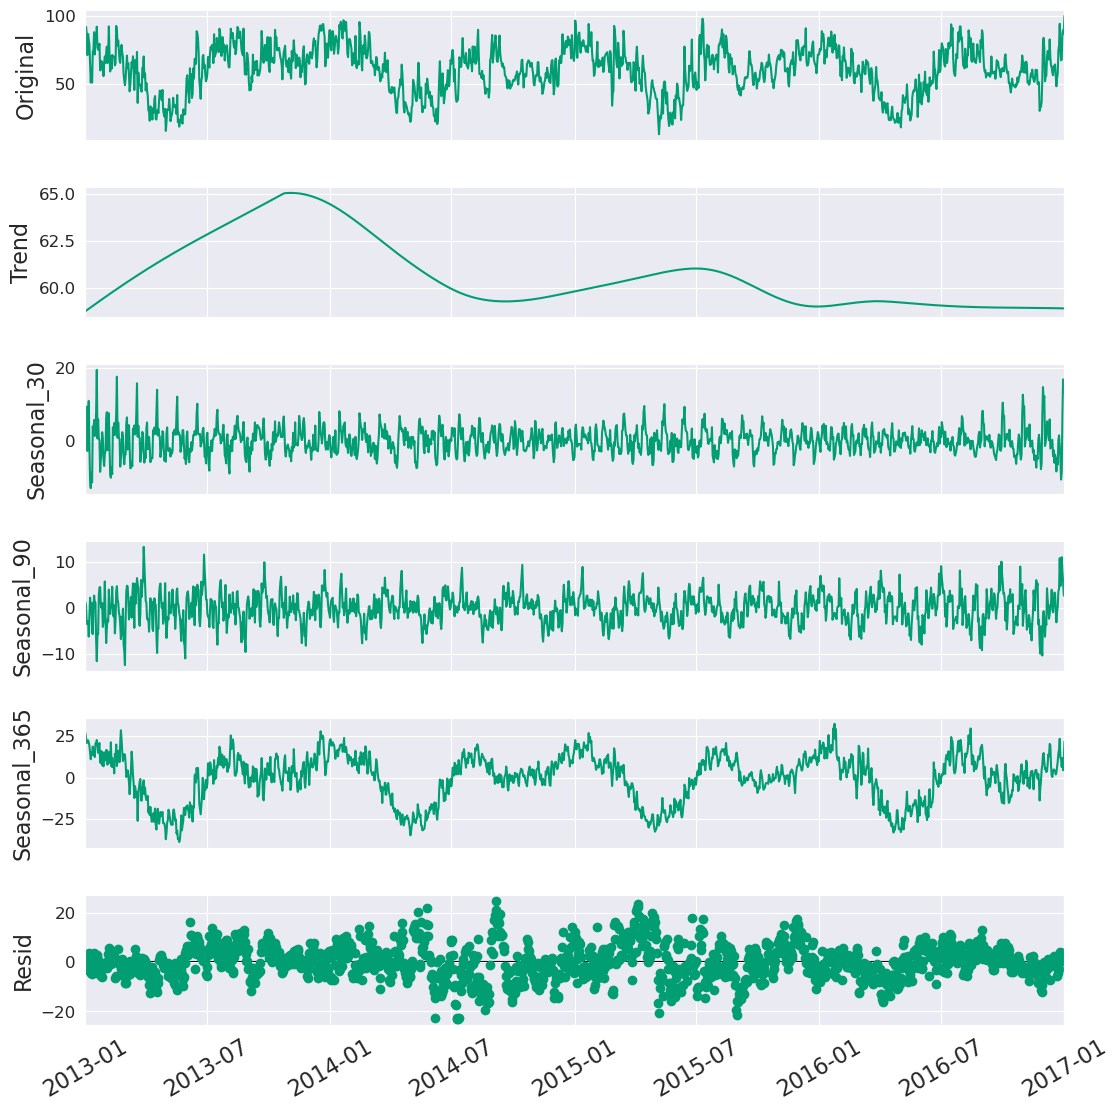

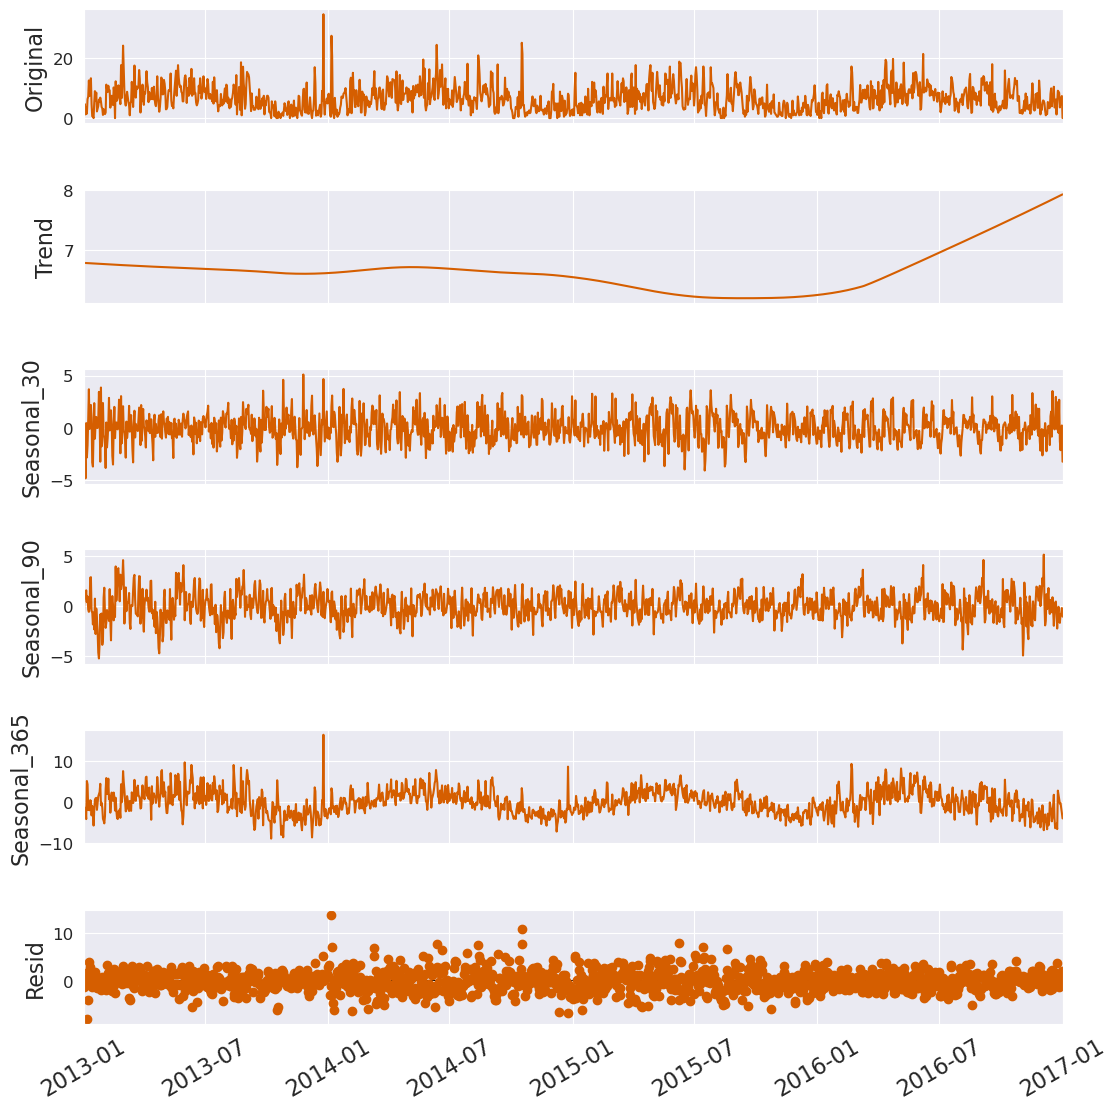

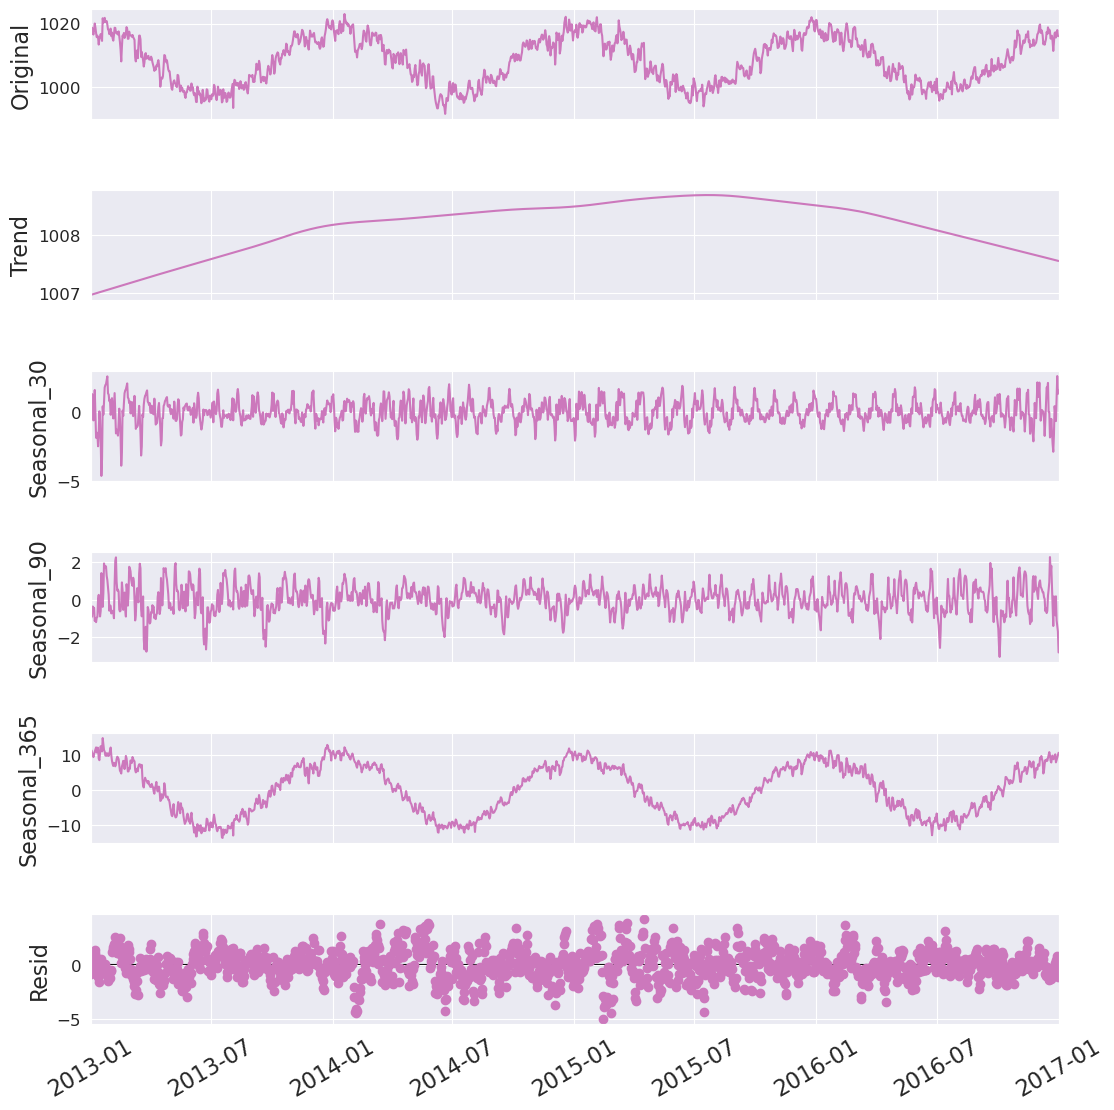

In [ ]:
from statsmodels.tsa.seasonal import MSTL

def multi_seasonal_decompose(df, var):
    
    # Get column index
    idx = df.columns.get_loc(var)-1
    
    # Get variable data and set index to date
    data = df[var]
    data.index = df['date']
    # Decompose
    res = MSTL(data, periods=(30, 90, 365)).fit()

    # Plot 
    fig = res.plot()
    fig.axes[0].set_title("")           # remove title
    fig.axes[0].set_ylabel("Original")  # add as ylabel instead
    
    # Set colors
    for ax in fig.axes:
        ax.lines[0].set_color(colors[idx])
        ax.tick_params(axis="y", labelsize=12)
        ax.yaxis.label.set_fontsize(16)

    fig.set_size_inches((12, 12))
    plt.tick_params(axis="x", rotation=30, labelsize=16)
    # plt.savefig(f"./images/{var}_MSTL.pdf", format="pdf
    plt.show()


for var in df.columns[1:]:
    multi_seasonal_decompose(df, var)
